#### **Step 0. Loading the Data from File Path**
- Download Data
- Import Libraries

In [3]:
import numpy as np
import pandas as pd
import prophet

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [4]:
from google.colab import drive # Load data from google drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C"
%ls -f

Mounted at /content/drive
/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C
data/                      Dataset_test_1.csv
model_train_LSTM.ipynb     Dataset_test_2.csv
Dataset_train_1.gsheet     Dataset_train_2.csv
Dataset_1.gsheet           test_1.csv
Dataset_2.gsheet           train_2.csv
data_financials.csv        data_2_preprocess.ipynb
data_econ.csv              result_1.csv
Dataset_1.csv              result_2.csv
Dataset_test_combined.csv  model_1_feature_importances.csv
Dataset_train_1.csv        model_2_feature_importances.csv
train_1.csv                model_2_performance.csv
data_1_preprocess.ipynb    Prediction_result.csv
Dataset_2.csv              model_1_performance.csv
test_2.csv                 model_train_TREE_official.ipynb


In [5]:
train_1 = pd.read_csv("train_1.csv")
test_1 = pd.read_csv("test_1.csv")

In [6]:
print(train_1[train_1['Bond Rating Rank'] == 0].shape)
print(test_1[train_1['Bond Rating Rank'] == 0].shape)
train_1.info()
test_1.info()

(6, 219)
(0, 174)


<ipython-input-6-5b21b4a72b95>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_1[train_1['Bond Rating Rank'] == 0].shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Columns: 219 entries, IssuePrice to Prev Bond Rating Rank
dtypes: float64(60), int64(159)
memory usage: 26.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 174 entries, IssuePrice to Country_USA
dtypes: float64(58), int64(116)
memory usage: 2.3 MB


#### **Step 1. Model 1 Training**
- Generate Y-value
- Train the Model

In [7]:
y_train_1 = train_1["Y"]
X_train_1 = train_1.drop(columns = ["Y"])

y_test_1 = test_1["Y"]
X_test_1 = test_1.drop(columns = ["Y"])

In [8]:
X_train_1.info()
y_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Columns: 218 entries, IssuePrice to Prev Bond Rating Rank
dtypes: float64(59), int64(159)
memory usage: 26.0 MB
<class 'pandas.core.series.Series'>
RangeIndex: 15620 entries, 0 to 15619
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
15620 non-null  float64
dtypes: float64(1)
memory usage: 122.2 KB


In [9]:
X_test_1.info()
X_test_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 173 entries, IssuePrice to Country_USA
dtypes: float64(57), int64(116)
memory usage: 2.2 MB


,IssuePrice,CouponFrequency,CouponRate,DenominationMinimum,FaceIssuedTotal,FaceIssuedUSD,FaceOutstanding,FaceOutstandingUSD,IsPublic,BondsCount,...,Country_CHL,Country_COL,Country_FIN,Country_FRA,Country_GBR,Country_IRL,Country_ITA,Country_JPN,Country_NLD,Country_USA
0,0.905450,0.090909,0.688958,0.09955,0.213382,0.213382,0.038466,0.038466,1,0.001481,...,0,0,0,0,0,1,0,0,0,0
1,0.905450,0.090909,0.688958,0.09955,0.213382,0.213382,0.038466,0.038466,1,0.001481,...,0,0,0,0,0,1,0,0,0,0
2,0.905450,0.090909,0.688958,0.09955,0.213382,0.213382,0.038466,0.038466,1,0.001481,...,0,0,0,0,0,1,0,0,0,0
3,0.905450,0.090909,0.688958,0.09955,0.213382,0.213382,0.038466,0.038466,1,0.001481,...,0,0,0,0,0,1,0,0,0,0
4,0.966144,0.090909,0.393468,0.00050,0.284893,0.284893,0.285357,0.285357,1,0.002962,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# @title Align Columns betw Testing set and Training set
X_train_1, X_test_1 = X_train_1.align(X_test_1, axis=1, join = 'outer')
X_train_1, X_test_1 = X_train_1.fillna(0), X_test_1.fillna(0)

In [11]:
X_train_1.info()
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Columns: 218 entries, AssetStatusDescription_Issued to Year
dtypes: float64(59), int64(159)
memory usage: 26.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 218 entries, AssetStatusDescription_Issued to Year
dtypes: float64(102), int64(116)
memory usage: 2.8 MB


In [12]:
X_train_1_prev_bond_rating = X_train_1.pop("Prev Bond Rating Rank")
X_test_1.pop("Prev Bond Rating Rank")

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1699    0.0
1700    0.0
1701    0.0
1702    0.0
1703    0.0
Name: Prev Bond Rating Rank, Length: 1704, dtype: float64

In [13]:
print(y_train_1.unique())
print(y_test_1.unique())

[10.  9.  8. 11. 12.  6.  5.  7.  4.  3.  1.  2.]
[ 8.  6. 10.  5. 12.  4.  9.  3.  7.  2.  1. 11.]


In [14]:
X_train_1.iloc[:, :50].info()
print(X_train_1.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Data columns (total 50 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   AssetStatusDescription_Issued                                                                15620 non-null  int64  
 1   Bond Rating Rank                                                                             15620 non-null  float64
 2   BondsCount                                                                                   15620 non-null  float64
 3   CASA Ratio                                                                                   15620 non-null  float64
 4   CD Non Equity Ratio                                                                          15620 non-null  float64
 5   Cash and Equivalents            

In [15]:
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 217 entries, AssetStatusDescription_Issued to Year
dtypes: float64(101), int64(116)
memory usage: 2.8 MB


In [16]:
# @title Generate Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from prophet import Prophet

# credit_rating_model_1 = GradientBoostingClassifier(
#     n_estimators=50,
#     max_depth=5,
#     min_samples_split=4,
#     min_samples_leaf=2,
#     loss='log_loss',
#     verbose = 1
# )

credit_rating_model_1 = RandomForestClassifier(
  # bootstrap=True,
  # class_weight="balanced_subsample",
  # criterion="gini",
  # max_features=None,
  # min_samples_leaf=5,
  # min_samples_split=18,
  # n_estimators=894,
  # verbose = 2
)

credit_spread_model_2 = RandomForestRegressor(
  n_estimators=100,
  max_features='log2',
  max_depth=None,
  min_samples_split=2,
  min_samples_leaf=1,
  bootstrap=True,
  verbose = 1
)

In [17]:
# @title Train the Model
credit_rating_model_1.fit(X_train_1, y_train_1)

RandomForestClassifier()

In [18]:
# @title Predict Credit Rating from Model 1
y_pred_1 = credit_rating_model_1.predict(X_test_1) # for testing

In [19]:
 # @title Find the Probability of Credit Migration
y_pred_proba = credit_rating_model_1.predict_proba(X_test_1)

In [20]:
normalized = y_pred_proba
print(y_pred_1)
accuracy = accuracy_score(y_test_1, y_pred_1, normalize=True, sample_weight=None)

print(normalized.shape, y_pred_1.shape)
credit_prob = np.zeros(y_pred_1.shape)
for i in range(y_pred_1.shape[0]):
  index = int(y_pred_1[i]) - 1
  credit_prob[i] = normalized[i][index]

[8. 8. 9. ... 5. 5. 5.]
(1704, 12) (1704,)


In [21]:
credit_prob = credit_prob / credit_prob.max()
credit_prob = [
    x + 0.1 if 0.4 <= x < 0.5 else
    x + 0.2 if 0.3 <= x < 0.4 else
    x + 0.3 if 0.0 <= x < 0.3 else
    x for x in credit_prob
  ]


In [22]:
print(pd.Series(credit_prob).unique())

[0.5943662  0.5084507  0.53661972 0.52253521 0.6056338  0.5915493
 0.57746479 0.58028169 0.63380282 0.64788732 0.61971831 0.56338028
 0.50704225 0.54929577 0.53802817 0.53521127 0.69014085 0.67605634
 0.66197183 0.59295775 0.55070423 0.56478873 0.81690141 0.77464789
 0.8028169  0.76056338 0.85915493 0.84507042 0.78873239 0.74647887
 0.83098592 0.57887324 0.91549296 0.88732394 0.87323944 0.52112676
 0.73239437 0.70422535 0.56619718 0.55211268 0.52394366 0.59577465
 0.56760563 0.71830986 1.         0.97183099 0.90140845 0.92957746
 0.94366197 0.50985915 0.95774648]


#### **Step 2. Evaluation of Model 1**
- F1, Precision, Recall, Accuracy
- Confusion Matrix

In [23]:
# @title Check Accuracy and Confusion Matrix

def evaluate_model_1(y_test, y_pred):
  print("Model 1 of Credit Rating:")
  print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
  print("Classification Report:", '\n', classification_report(y_test, y_pred, zero_division = 0))
  print("Confusion Matrix:", '\n',)
  ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)

Model 1 of Credit Rating:
Accuracy: 0.625
Classification Report: 
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00        36
         3.0       0.67      0.16      0.26        87
         4.0       0.46      0.65      0.54       277
         5.0       0.70      0.51      0.59       506
         6.0       0.61      0.85      0.71       478
         7.0       0.74      0.52      0.61        77
         8.0       0.92      0.70      0.80       206
         9.0       0.00      0.00      0.00         5
        10.0       0.82      1.00      0.90        18
        11.0       0.50      0.67      0.57         6
        12.0       0.00      0.00      0.00         4

    accuracy                           0.62      1704
   macro avg       0.45      0.42      0.41      1704
weighted avg       0.64      0.62      0.61      1704

Confusion Matrix: 



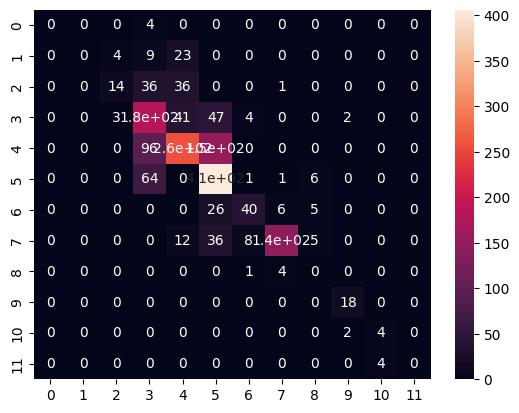

In [24]:
evaluate_model_1(y_test_1, y_pred_1)

#### **Step 3. Integration between Model 1 and Model 2**
- calculate credit migration
- combine prediction


In [25]:
# @title Calculate Credit Migration
Prev_Bond_Rating_Rank = (pd.read_csv("Dataset_test_1.csv"))["Bond Rating Rank"]

credit_migration = (y_pred_1 - Prev_Bond_Rating_Rank).rename("Credit Migration")
credit_migration_X_2 = (credit_migration - credit_migration.min())/(credit_migration.max() - credit_migration.min()) # perform Normalization: Min-Max Scalar

In [26]:
train_2 = pd.read_csv("train_2.csv")
test_2 = pd.read_csv("test_2.csv")

In [27]:
y_train_2 = train_2['Y']
X_train_2 = train_2.drop(['Y'], axis = 1)

In [28]:
test_2.info()
y_test_1.info()
credit_migration_X_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 107 entries, IssuePrice to Y
dtypes: float64(36), int64(71)
memory usage: 1.4 MB
<class 'pandas.core.series.Series'>
RangeIndex: 1704 entries, 0 to 1703
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
1704 non-null   float64
dtypes: float64(1)
memory usage: 13.4 KB
<class 'pandas.core.series.Series'>
RangeIndex: 1704 entries, 0 to 1703
Series name: Credit Migration
Non-Null Count  Dtype  
--------------  -----  
1704 non-null   float64
dtypes: float64(1)
memory usage: 13.4 KB


In [29]:
# @title Generate X_test_2
X_test_2 = pd.concat([test_2, pd.Series(y_test_1 - Prev_Bond_Rating_Rank, name = "Credit Migration")], axis = 1)

y_test_2 = X_test_2["Y"]
X_test_2 = X_test_2.drop(columns = ['Y'])

In [30]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15996 entries, 0 to 15995
Columns: 162 entries, IssuePrice to Credit Migration
dtypes: float64(35), int64(127)
memory usage: 19.8 MB


In [31]:
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 107 entries, IssuePrice to Credit Migration
dtypes: float64(36), int64(71)
memory usage: 1.4 MB


In [32]:
# @title Align Columns betw Testing set and Training set

X_train_2, X_test_2 = X_train_2.align(X_test_2, axis=1, join = 'outer')
X_train_2, X_test_2 = X_train_2.fillna(0), X_test_2.fillna(0)

In [33]:
X_train_2.iloc[:, :50].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15996 entries, 0 to 15995
Data columns (total 50 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   AssetStatusDescription_Issued                           15996 non-null  int64  
 1   Bond Rating Rank                                        15996 non-null  float64
 2   BondsCount                                              15996 non-null  float64
 3   CommonName_Aib Group PLC                                15996 non-null  int64  
 4   CommonName_Akbank TAS                                   15996 non-null  int64  
 5   CommonName_BNP Paribas SA                               15996 non-null  int64  
 6   CommonName_Banc of California Inc                       15996 non-null  int64  
 7   CommonName_Banco Santander-Chile                        15996 non-null  int64  
 8   CommonName_Banco de Bogota SA       

In [34]:
# @title Output the result of Model 1

Dataset_1 = pd.read_csv("Dataset_test_1.csv")

Prediction_result = pd.concat([
    Dataset_1.iloc[:, 0], # identifiers
    Dataset_1['Year'], # Year
    Dataset_1['Month'], # Month
    Prev_Bond_Rating_Rank.rename("Prev Bond Rating").reset_index(drop = True),
    pd.Series(y_test_1, name = "Correct Bond Rating"),
    pd.Series(y_pred_1, name = "Pred Bond Rating"),
    pd.Series(y_test_1 - Prev_Bond_Rating_Rank, name = "Correct Credit Migration"),
    credit_migration.rename("Pred Credit Migration"),
    pd.Series(credit_prob, name = "Probability of Migration")]
    , axis = 1
  )

model_1_result = pd.DataFrame()
for name, group in Prediction_result.groupby("RIC"):
  # print(group.iloc[-1, :].shape)
  model_1_result = pd.concat([model_1_result, group.iloc[-1:, :]], axis = 0)

model_1_result["Month"] = 8
model_1_result_csv = model_1_result.to_csv(index=False)

model_1_result_csv = model_1_result.sort_values(by = ["RIC"]).to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/result_1.csv', 'w') as f:
  f.write(model_1_result_csv)

In [35]:
model_1_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 3 to 1703
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RIC                       364 non-null    object 
 1   Year                      364 non-null    float64
 2   Month                     364 non-null    int64  
 3   Prev Bond Rating          364 non-null    float64
 4   Correct Bond Rating       364 non-null    float64
 5   Pred Bond Rating          364 non-null    float64
 6   Correct Credit Migration  364 non-null    float64
 7   Pred Credit Migration     364 non-null    float64
 8   Probability of Migration  364 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 28.4+ KB


In [36]:
X_test_2.info()
X_test_2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Columns: 165 entries, AssetStatusDescription_Issued to Year
dtypes: float64(94), int64(71)
memory usage: 2.1 MB


,AssetStatusDescription_Issued,Bond Rating Rank,BondsCount,CommonName_Aib Group PLC,CommonName_Akbank TAS,CommonName_BNP Paribas SA,CommonName_Banc of California Inc,CommonName_Banco Santander-Chile,CommonName_Banco de Bogota SA,CommonName_Banco de Chile,...,Ticker_SUMFG,Ticker_TD,Ticker_TFC,Ticker_VAKBN,Ticker_WBC,Ticker_WBS,Ticker_WFC,Ticker_YKBNK,Unemployment,Year
0,1,0.636364,0.0,1,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176991,1
1,1,0.636364,0.0,1,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168142,1
2,1,0.636364,0.0,1,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168142,1
3,1,0.636364,0.0,1,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132743,1
4,1,0.454545,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088496,1


#### **Step 4. Model 2 Training**
- Train the Model

In [37]:
# @title Train the Model
credit_spread_model_2.fit(X_train_2, y_train_2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s


RandomForestRegressor(max_features='log2', verbose=1)

In [38]:
# @title Predict Credit Spread from Model 2
y_2_pred = credit_spread_model_2.predict(X_test_2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [39]:
# @title Output the result of Model 2

Dataset_2 = pd.read_csv("Dataset_test_2.csv")

prev_credit_spread = Dataset_2["Credit Spread"].rename("Prev Credit Spread")
correct_credit_spread = Dataset_2['Y'].rename("Correct Credit Spread")
pred_credit_spread = pd.Series(y_2_pred, name = "Pred Credit Spread")

Prediction_result = pd.concat([
      Dataset_2.iloc[:, 0], # identifiers
      Dataset_2['Year'], # Year
      Dataset_2['Month'], # Month
      prev_credit_spread,
      correct_credit_spread,
      pred_credit_spread
    ], axis = 1
  )

model_2_result = pd.DataFrame()
for name, group in Prediction_result.groupby("RIC"):
  # print(group.iloc[-1, :].shape)
  model_2_result = pd.concat([model_2_result, group.iloc[-1:, :]], axis = 0)

model_2_result["Month"] = 8

model_2_result_csv = model_2_result.sort_values(by = ["RIC"]).to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/result_2.csv', 'w') as f:
  f.write(model_2_result_csv)

In [40]:
for name, group in model_2_result.groupby(by = ["Year", "Month"]):
    print(name, group.shape, group['RIC'].unique().shape)

(2023.0, 8) (364, 6) (364,)


#### **Step 5. Evaluation of Model 2**
- F1, Precision, Recall, Accuracy
- Confusion Matrix

In [64]:
# Check Accuracy and MSE

def evaluate_model_2(y_test, y_pred):

  print("Model 2 of Credit Spread:")
  print("mae(average prediction error ignoring outliers): ", mean_absolute_error(y_test, y_pred))
  print("rmse(average prediction error including outliers): ", np.sqrt(mean_squared_error(y_test, y_pred)))
  print("r2: ", r2_score(y_test, y_pred))

  # Add a constant term for the intercept in the regression model
  df = pd.read_csv('result_2.csv')

  # Assuming you have a DataFrame named 'df' with columns 'Y' and 'Pred Credit Spread'
  y = y_test
  pred_credit_spread = y_2_pred

  # Add a constant term for the intercept in the regression model
  X = sm.add_constant(pred_credit_spread)

  # Fit the linear regression model
  model = sm.OLS(y, X)
  results = model.fit()

  # Plot the regression line
  xmin = plt.xlim()[0]
  xmax = plt.xlim()[1]
  plt.plot([xmin, xmax], [xmin, xmax], 'k', lw=2)
  plt.scatter(pred_credit_spread, y)
  plt.plot(pred_credit_spread, results.fittedvalues, color='red')
  plt.xlabel('Pred Credit Spread')
  plt.ylabel('Y')
  plt.title('Linear Regression: Y vs Pred Credit Spread')
  plt.show()

  # Print the summary statistics including t-statistic and p-value
  print(results.summary())

Model 2 of Credit Spread:
mae(average prediction error ignoring outliers):  0.005889631463992287
rmse(average prediction error including outliers):  0.007248039055805807
r2:  -0.03692264793218647


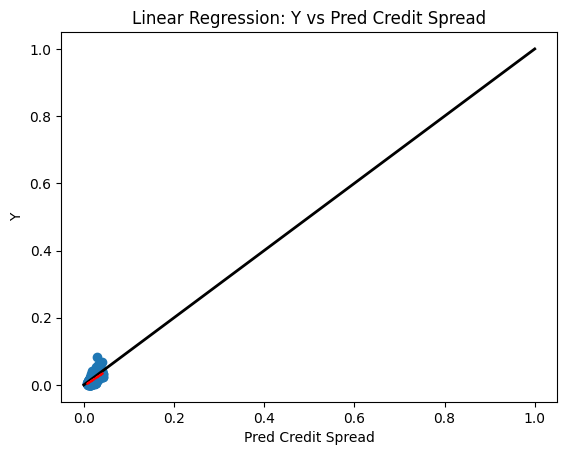

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1782.
Date:                Fri, 18 Aug 2023   Prob (F-statistic):          4.15e-267
Time:                        07:30:28   Log-Likelihood:                 6619.1
No. Observations:                1704   AIC:                        -1.323e+04
Df Residuals:                    1702   BIC:                        -1.322e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.000     -8.730      0.0

In [65]:
evaluate_model_2(y_test_2, y_2_pred)

#### **Step 6. Interpretation**
- ROC Curve
- Feature Importance
- SHAP Values

In [43]:
def interpret_model(data, model, num_features):
  features = data.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)

  plt.figure(figsize=(5,5))
  plt.title('Feature Importances')

  # only plot the customized number of features
  plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.show()

Model 1 Interpretation: 


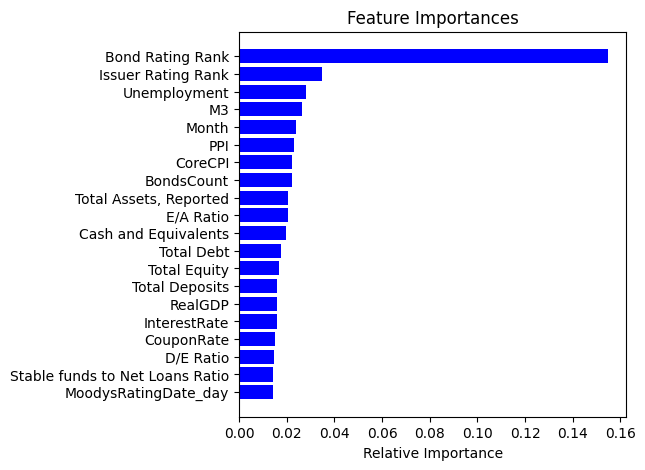

In [44]:
print("Model 1 Interpretation: ")
interpret_model(X_test_1, credit_rating_model_1 , 20)


In [45]:
model_1_feature_importances = pd.DataFrame({'columns': X_test_1.columns, 'Feature Importances': credit_rating_model_1.feature_importances_})

model_1_feature_importances_csv = model_1_feature_importances.to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/model_1_feature_importances.csv', 'w') as f:
  f.write(model_1_feature_importances_csv)

In [46]:
report = classification_report(y_test_1, y_pred_1, output_dict=True)
classification_summary = pd.DataFrame(report)

classification_summary_csv = classification_summary.to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/model_1_performance.csv', 'w') as f:
  f.write(classification_summary_csv)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
classification_summary.info()
classification_summary.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, precision to support
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1.0           4 non-null      float64
 1   2.0           4 non-null      float64
 2   3.0           4 non-null      float64
 3   4.0           4 non-null      float64
 4   5.0           4 non-null      float64
 5   6.0           4 non-null      float64
 6   7.0           4 non-null      float64
 7   8.0           4 non-null      float64
 8   9.0           4 non-null      float64
 9   10.0          4 non-null      float64
 10  11.0          4 non-null      float64
 11  12.0          4 non-null      float64
 12  accuracy      4 non-null      float64
 13  macro avg     4 non-null      float64
 14  weighted avg  4 non-null      float64
dtypes: float64(15)
memory usage: 512.0+ bytes


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.666667,0.462725,0.697297,0.608696,0.740741,0.923567,0.0,0.818182,0.500000,0.0,0.625,0.451489,0.642596
recall,0.0,0.0,0.160920,0.649819,0.509881,0.849372,0.519481,0.703883,0.0,1.000000,0.666667,0.0,0.625,0.421669,0.625000
f1-score,0.0,0.0,0.259259,0.540541,0.589041,0.709170,0.610687,0.798898,0.0,0.900000,0.571429,0.0,0.625,0.414919,0.610650
support,4.0,36.0,87.000000,277.000000,506.000000,478.000000,77.000000,206.000000,5.0,18.000000,6.000000,4.0,0.625,1704.000000,1704.000000


Model 2 Interpretation: 


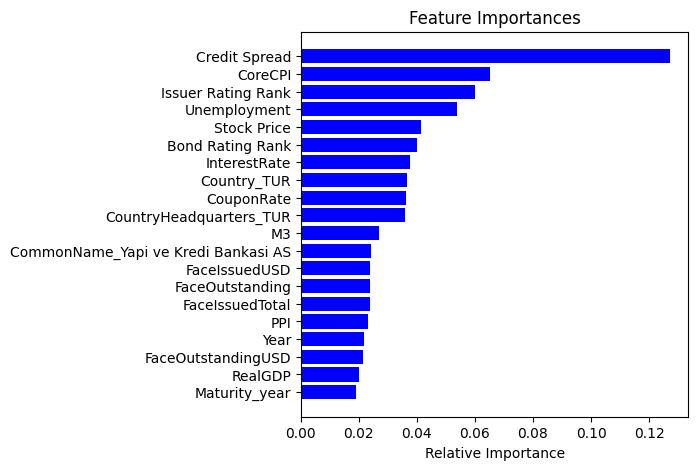

In [48]:
print("Model 2 Interpretation: ")
interpret_model(X_test_2, credit_spread_model_2, 20)

In [49]:
model_2_feature_importances = pd.DataFrame({'columns': X_test_2.columns, 'Feature Importances': credit_spread_model_2.feature_importances_})

model_2_feature_importances_csv = model_2_feature_importances.to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/model_2_feature_importances.csv', 'w') as f:
  f.write(model_2_feature_importances_csv)

In [50]:
# Fit model
model = sm.OLS(y_test_2, y_2_pred)
results = model.fit()
summary = results.summary()

regression_summary = pd.DataFrame()
# for i, table in enumerate(results.summary2().tables):
#   regression_summary = pd.concat([regression_summary, table], axis = 1)
results_as_html = results.summary().tables[1].as_html()
regression_summary = pd.read_html(results_as_html, header=0, index_col=0)[0]

regression_summary_csv = regression_summary.to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/model_2_performance.csv', 'w') as f:
  f.write(regression_summary_csv)

In [51]:
regression_summary.info()
regression_summary.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, x1 to x1
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coef     1 non-null      float64
 1   std err  1 non-null      float64
 2   t        1 non-null      float64
 3   P>|t|    1 non-null      float64
 4   [0.025   1 non-null      float64
 5   0.975]   1 non-null      float64
dtypes: float64(6)
memory usage: 56.0+ bytes


,coef,std err,t,P>|t|,[0.025,0.975]
x1,0.719,0.007,107.266,0.0,0.706,0.732


#### **Step 7. Output Prediction Result**
- Probability
- Credit Rating
- Credit Spread


In [52]:
temp = pd.concat([
      model_2_result,
      model_1_result["Correct Credit Migration"],
      model_1_result["Pred Credit Migration"],
      model_1_result["Probability of Migration"]
    ], axis = 1
  )

print(temp.shape)

Prediction_result = pd.DataFrame()
for name, group in temp.groupby("RIC"):
  # print(group.iloc[-1, :].shape)
  Prediction_result = pd.concat([Prediction_result, group.iloc[-1:, :]], axis = 0)

Prediction_result["Month"] = 8
Prediction_result_csv = Prediction_result.to_csv(index=False)

with open('/content/drive/My Drive/Colab_Notebooks/TEAM3_TEMG4940C/Prediction_result.csv', 'w') as f:
  f.write(Prediction_result_csv)

(364, 9)


In [53]:
Prediction_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 3 to 1703
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RIC                       364 non-null    object 
 1   Year                      364 non-null    float64
 2   Month                     364 non-null    int64  
 3   Prev Credit Spread        364 non-null    float64
 4   Correct Credit Spread     364 non-null    float64
 5   Pred Credit Spread        364 non-null    float64
 6   Correct Credit Migration  364 non-null    float64
 7   Pred Credit Migration     364 non-null    float64
 8   Probability of Migration  364 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 28.4+ KB


#### **Step 8. Optimization**
- K-fold Cross Validation


In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Hyperparameters of Random Forest Classifier
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
max_features = ["sqrt", "log2", None]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 21, num = 10)]
class_weight = ["balanced", "balanced_subsample"]
criterion = ["gini", "entropy", "log_loss"]
bootstrap = [True, False]

# Create the random grid
model_1_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'criterion': criterion,
               'bootstrap': bootstrap,
               'verbose': [1]}

# RandomForestRegressor hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2', None]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 21, num = 10)]
bootstrap = [True, False]

# Create random grid
model_2_random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'verbose': [1]}

In [55]:
# # Find range of optimized values of hyperparameters by RandomCV
# model_1 = RandomForestClassifier()

# rf_random_1 = RandomizedSearchCV(estimator = model_1, param_distributions = model_1_random_grid, n_iter = 10, cv = 5, verbose = 2, random_state=42,)
# rf_random_1.fit(X_train_1, y_train_1)

# model_2 = RandomForestRegressor()

# rf_random_2 = RandomizedSearchCV(estimator = model_2, param_distributions = model_2_random_grid, n_iter = 10, cv = 5, verbose = 2, random_state=42,)
# rf_random_2.fit(X_train_2, y_train_2)


In [56]:
# Find optimized value of hyperparameters by GridCV

# rf_random_1.best_estimator_.fit(X_train_1, y_train_1)
# rf_random_2.best_estimator_.fit(X_train_1, y_train_1)

In [57]:
# y_optimized_pred_1 = rf_random_1.best_estimator_.predict(X_test_1)
# y_optimized_pred_2 = rf_random_2.best_estimator_.predict(X_test_2)

In [58]:
# evaluate_model_1(y_test_1, y_optimized_pred_1)
# print("\nPrevious Accuracy", accuracy_score(y_test_1, y_pred_1))
# print("Improvement: ", accuracy_score(y_test_1, y_optimized_pred_1) - accuracy_score(y_test_1, y_pred_1))
# print(rf_random_2.best_parameters)

In [59]:
# evaluate_model_2(y_test_2, y_optimized_pred_2)
# print("\nPrevious Rmse", np.sqrt(mean_squared_error(y_test_2, y_2_pred)))
# print("Improvement: ",  np.sqrt(mean_squared_error(y_test_2, y_optimized_pred_2) -  np.sqrt(mean_squared_error(y_test_2, y_2_pred))))